In [1]:
import duckdb 
import pandas as pd
import plotly.express as px

In [2]:
db = duckdb.connect('transit.db')
db.sql('')

In [3]:
db.sql("SHOW TABLES")

┌────────────────────────────┐
│            name            │
│          varchar           │
├────────────────────────────┤
│ agency                     │
│ calendar                   │
│ calendar_dates             │
│ direction_names_exceptions │
│ directions                 │
│ feed_info                  │
│ route_names_exceptions     │
│ routes                     │
│ rt_alerts                  │
│ rt_position                │
│ rt_trip                    │
│ shapes                     │
│ signup_periods             │
│ stop_order_exceptions      │
│ stop_times                 │
│ stops                      │
│ transfers                  │
│ trips                      │
├────────────────────────────┤
│          18 rows           │
└────────────────────────────┘

In [6]:
db.sql("SELECT * FROM rt_position")

┌──────────┬────────────┬───────────────────────┬──────────┬──────────────┬───────────┬─────────────┬───────────────────────┬────────────────┬─────────────────────┬─────────┬────────────┬───────────────┐
│ trip_id  │ start_date │ schedule_relationship │ route_id │ direction_id │ latitude  │  longitude  │ current_stop_sequence │ current_status │      timestamp      │ stop_id │ vehicle_id │ vehicle_label │
│ varchar  │    date    │         int32         │ varchar  │   varchar    │   float   │    float    │        varchar        │    varchar     │      timestamp      │ varchar │  varchar   │    varchar    │
├──────────┼────────────┼───────────────────────┼──────────┼──────────────┼───────────┼─────────────┼───────────────────────┼────────────────┼─────────────────────┼─────────┼────────────┼───────────────┤
│ 14121841 │ 2024-11-30 │                     0 │ 30055    │ 0            │ 49.286415 │  -123.14038 │ 1                     │ 2              │ 2024-12-01 02:02:40 │ 1       │ 19529    

In [4]:
clean_queries = {
    'rt_trip_1970': """DELETE FROM rt_trip WHERE year(next_stop_arrival_time) == 1970""",
    'rt_position_1970': """DELETE FROM rt_position WHERE year(timestamp) = 1970""",
    'rt_position_filter_max_latitude': """DELETE FROM rt_position WHERE latitude < 49 """,
    'rt_position_filter_min_latitude': """DELETE FROM rt_position WHERE latitude > 49.5 """,
    'rt_position_filter_max_longitude': """DELETE FROM rt_position WHERE longitude < -123.5 """,
    'rt_position_filter_min_longitude': """DELETE FROM rt_position WHERE longitude > -122.3 """,
}

for query in clean_queries.values():
    db.execute(query)
    
# Delete all 1970 dates in realtime trip and position data as they are originally null values
#db.sql("""DELETE FROM rt_trip WHERE year(next_stop_arrival_time) == 1970""")
#db.sql("""SELECT * FROM rt_trip WHERE year(next_stop_arrival_time) == 1970""").show() #for testing
#db.sql("""DELETE FROM rt_position WHERE year(timestamp) = 1970""") #for testing
#remove null latitude and longitudes

#db.sql("""SELECT * FROM rt_position WHERE latitude < 49 """).show()
#db.sql("""SELECT * FROM rt_position WHERE latitude > 49.5 """).show()
#db.sql("""SELECT * FROM rt_position WHERE longitude < -123.5 """).show()
#db.sql("""SELECT * FROM rt_position WHERE longitude > -122.3 """).show()

#db.sql("""DELETE FROM rt_position WHERE longitude = 0.0 """)
#db.sql("""SELECT * FROM rt_position WHERE latitude = 0.0 """).show()
db.sql("""SELECT * FROM shapes WHERE shape_id = '4484' """).show()

#db.sql("""SELECT max(longitude) FROM rt_position""").show()


#remove handy dart entries





┌──────────┬──────────────┬──────────────┬───────────────────┬─────────────────────┐
│ shape_id │ shape_pt_lat │ shape_pt_lon │ shape_pt_sequence │ shape_dist_traveled │
│ varchar  │    double    │    double    │       int32       │       double        │
├──────────┼──────────────┼──────────────┼───────────────────┼─────────────────────┤
│ 4484     │    49.224743 │   -122.89178 │                 1 │                 0.0 │
└──────────┴──────────────┴──────────────┴───────────────────┴─────────────────────┘



In [11]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point


plt.scatter(x=df['Longitude'], y=df['Latitude'])
db.sql("""SELECT * FROM rt_position WHERE longitude = 0.0 """).show()
plt.show()

NameError: name 'df' is not defined

In [12]:
db.sql("SELECT count(*) FROM rt_trip ").show()

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1702801 │
└──────────────┘



In [13]:
db.sql("SELECT * FROM rt_trip").show()

┌──────────┬────────────┬───────────────────────┬──────────┬──────────────┬────────────────────┬─────────────────────────┬────────────────────────┬───────────────────────────┬──────────────────────────┬──────────────┬─────────────────────────────────┬────────────┬───────────────┐
│ trip_id  │ start_date │ schedule_relationship │ route_id │ direction_id │ next_stop_sequence │ next_stop_arrival_delay │ next_stop_arrival_time │ next_stop_departure_delay │ next_stop_departure_time │ next_stop_id │ next_stop_schedule_relationship │ vehicle_id │ vehicle_label │
│ varchar  │    date    │         int32         │ varchar  │   varchar    │      varchar       │        interval         │       timestamp        │         interval          │        timestamp         │   varchar    │             varchar             │  varchar   │    varchar    │
├──────────┼────────────┼───────────────────────┼──────────┼──────────────┼────────────────────┼─────────────────────────┼────────────────────────┼──────────

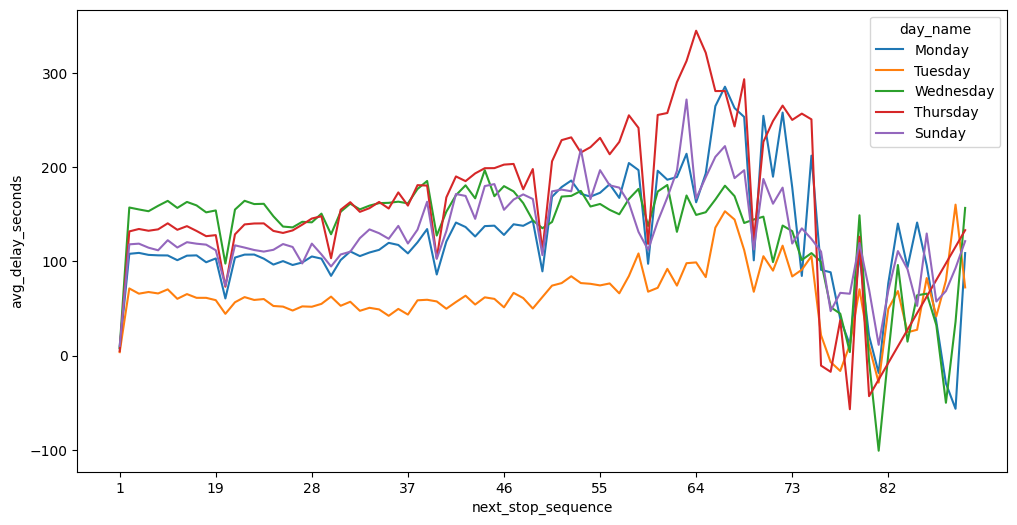

In [15]:
day_names = {
    0: 'Monday',
    1: 'Tuesday', 
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

results = db.sql("""SELECT
            dayofweek(start_date) as day_of_week, 
            avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds,
            next_stop_sequence,
        FROM rt_trip

        GROUP BY day_of_week,next_stop_sequence
        ORDER BY day_of_week,next_stop_sequence""").df()

results['day_name'] = results['day_of_week'].map(day_names)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x="next_stop_sequence", y="avg_delay_seconds",
    hue="day_name", 
)
plt.xticks(range(0, 90, 10))

plt.show()


In [24]:
db.sql("""SELECT 
        dayofweek(start_date) as day_of_week,
        avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds
        FROM rt_trip
        GROUP BY dayofweek(start_date)
        ORDER BY day_of_week""").show()

┌─────────────┬────────────────────┐
│ day_of_week │ avg_delay_seconds  │
│    int64    │       double       │
├─────────────┼────────────────────┤
│           0 │ 103.64855533345448 │
│           1 │  58.79149610345123 │
│           2 │ 146.49568133857557 │
│           3 │ 134.22390488637802 │
│           6 │  116.6080359676504 │
└─────────────┴────────────────────┘



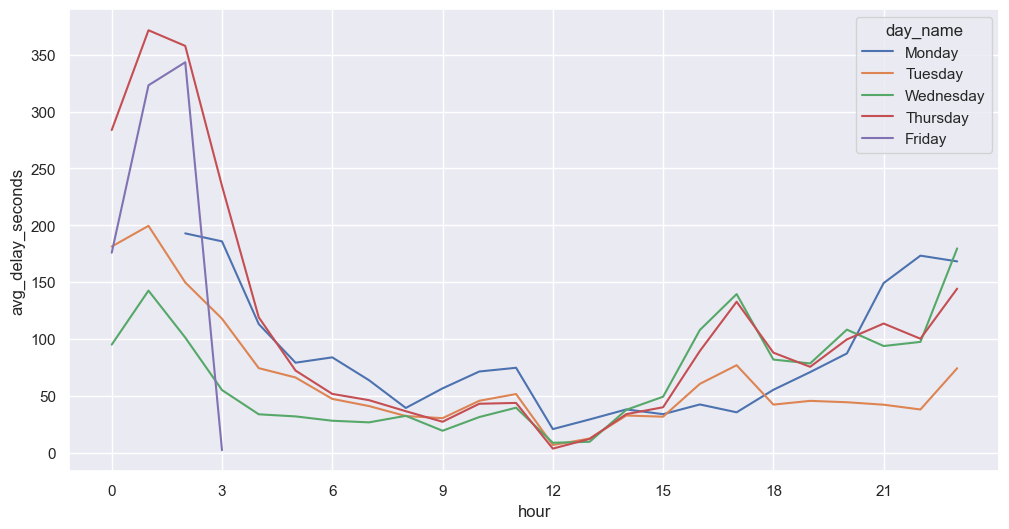

In [7]:
#grouped by day of week and hour

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

day_names = {
    0: 'Monday',
    1: 'Tuesday', 
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

results = db.sql("""SELECT 
            dayofweek(next_stop_arrival_time) as day_of_week,
            hour(next_stop_arrival_time) as hour,
            avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds,
        FROM rt_trip
        GROUP BY day_of_week, hour
        ORDER BY day_of_week,hour""").df()

results['day_name'] = results['day_of_week'].map(day_names)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x="hour", y="avg_delay_seconds",
    hue="day_name", 
)
plt.xticks(range(0, 24, 3))

plt.show()



In [178]:
route_id_by_hour = db.sql("""SELECT 
            route_id,
            hour(next_stop_arrival_time) as hour,
            avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds
        FROM rt_trip
        GROUP BY route_id, hour
        ORDER BY avg_delay_seconds""").df()
print(route_id_by_hour)
"""
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=route_id_by_hour,
    x="hour", y="avg_delay_seconds",
    hue="route_id", 
)
plt.xticks(range(0, 24, 3))

plt.show()
"""

     route_id  hour  avg_delay_seconds
0       30046    11       -1886.000000
1       36799    12       -1510.000000
2       38311    12       -1160.500000
3       31821    12       -1114.000000
4        6806    12       -1048.000000
...       ...   ...                ...
3952    11693     4        2250.455882
3953             19        2307.655405
3954              1        2358.918033
3955              3        2374.304000
3956     6743    17        2879.100000

[3957 rows x 3 columns]


In [6]:
%pip install dash
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)                                                    ##incomplete. fix or remove from statement


app.layout = html.Div([
    html.H4('Average delay by hour of day for all bus lines'),
    dcc.Graph(id="graph"),
    dcc.Checklist(
        id="checklist",
        options=["Asia", "Europe", "Africa","Americas","Oceania"],
        value=["Americas", "Oceania"],
        inline=True
    ),
])
# remove up to here if not fixing
results = db.sql("""SELECT  route_short_name,
                            hour(next_stop_arrival_time):: int as hour,
                            avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds
                    FROM routes 
                    LEFT JOIN rt_trip 
                    ON routes.route_id = rt_trip.route_id
                    WHERE starts_with(route_short_name,'R')
                    GROUP BY route_short_name, hour
                    ORDER BY hour, avg_delay_seconds""").df()

fig = px.line(results, x="hour", y="avg_delay_seconds", color='route_short_name')
fig.show()



Note: you may need to restart the kernel to use updated packages.


In [60]:
db.sql("""SELECT *
                    FROM routes 
                    LEFT JOIN rt_trip 
                    ON routes.route_id = rt_trip.route_id
                    WHERE starts_with(route_short_name,'R')
                    ORDER BY next_stop_arrival_delay""").show()

┌──────────┬───────────┬──────────────────┬─────────────────┬────────────┬────────────┬───────────┬─────────────┬──────────────────┬──────────┬────────────┬───────────────────────┬──────────┬──────────────┬────────────────────┬─────────────────────────┬────────────────────────┬───────────────────────────┬──────────────────────────┬──────────────┬─────────────────────────────────┬────────────┬───────────────┐
│ route_id │ agency_id │ route_short_name │ route_long_name │ route_desc │ route_type │ route_url │ route_color │ route_text_color │ trip_id  │ start_date │ schedule_relationship │ route_id │ direction_id │ next_stop_sequence │ next_stop_arrival_delay │ next_stop_arrival_time │ next_stop_departure_delay │ next_stop_departure_time │ next_stop_id │ next_stop_schedule_relationship │ vehicle_id │ vehicle_label │
│ varchar  │  varchar  │     varchar      │     varchar     │  varchar   │  varchar   │  varchar  │   varchar   │     varchar      │ varchar  │    date    │         int32      

In [69]:
results = db.sql("""SELECT      route_short_name,
                                next_stop_arrival_time,
                                EXTRACT(EPOCH FROM next_stop_arrival_delay) as avg_delay_seconds,
                                year(next_stop_arrival_time) as year
                    FROM routes 
                    LEFT JOIN rt_trip 
                    ON routes.route_id = rt_trip.route_id
                    WHERE starts_with(route_short_name,'R')
                    ORDER BY next_stop_arrival_delay""").df()
print(results[results['year'] != 2024])

      route_short_name next_stop_arrival_time  avg_delay_seconds  year
20741               R6             1970-01-01                0.0  1970
20973               R4             1970-01-01                0.0  1970
20974               R4             1970-01-01                0.0  1970
20975               R4             1970-01-01                0.0  1970
20976               R4             1970-01-01                0.0  1970
...                ...                    ...                ...   ...
25595               R4             1970-01-01                0.0  1970
25629               R4             1970-01-01                0.0  1970
25686               R1             1970-01-01                0.0  1970
25702               R1             1970-01-01                0.0  1970
25703               R4             1970-01-01                0.0  1970

[435 rows x 4 columns]


In [20]:
db.sql("""SELECT vehicle_id,
                trip_id
        FROM rt_trip
        GROUP BY vehicle_id
        count(unique(trip))""").show()

ParserException: Parser Error: syntax error at or near "count"

In [5]:
results = db.sql("""SELECT  route_short_name,
                            hour(next_stop_arrival_time) as hour,
                            avg(EXTRACT(EPOCH FROM next_stop_arrival_delay)) as avg_delay_seconds
                    FROM routes 
                    LEFT JOIN rt_trip 
                    ON routes.route_id = rt_trip.route_id
                    WHERE starts_with(route_short_name,'R')
                    GROUP BY route_short_name, hour
                    ORDER BY avg_delay_seconds, hour""").df()
print (results)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x="hour", y="avg_delay_seconds",
    hue="route_short_name", 
)
plt.xticks(range(0, 24, 3))

plt.show()



    route_short_name  hour  avg_delay_seconds
0                 R2    12       -1160.500000
1                 R2    13        -102.362205
2                 R2     5        -101.823741
3                 R3     8         -98.000000
4                 R3    18         -72.555556
..               ...   ...                ...
126               R2     1         255.557522
127               R4     0         368.141335
128               R4     2         402.268456
129               R5    10         425.027778
130               R4     1         524.031108

[131 rows x 3 columns]


NameError: name 'plt' is not defined

In [22]:
db.sql("""SELECT
        stop_sequence::int as stop_sequence,
        trip_short_name,
        ifnull(shape_dist_traveled, 0) as shape_dist_traveled,
        COALESCE(
            shape_dist_traveled - LAG(shape_dist_traveled) OVER (
                PARTITION BY trip_id 
                ORDER BY stop_sequence::int
            )
        ) as distance_from_prev_stop,
        stop_id,
        trip_id
    FROM stop_times
    WHERE trip_short_name != NULL
    ORDER BY distance_from_prev_stop DESC NULLS LAST
    """)

BinderException: Binder Error: Referenced column "trip_short_name" not found in FROM clause!
Candidate bindings: "stop_times.trip_id", "stop_times.arrival_time", "stop_times.timepoint", "stop_times.shape_dist_traveled", "stop_times.stop_id"

In [180]:
db.sql("""SELECT * from stop_times where trip_id = '14054659'""").show()

┌──────────┬──────────────┬────────────────┬─────────┬───────────────┬───────────────┬─────────────┬───────────────┬─────────────────────┬───────────┐
│ trip_id  │ arrival_time │ departure_time │ stop_id │ stop_sequence │ stop_headsign │ pickup_type │ drop_off_type │ shape_dist_traveled │ timepoint │
│ varchar  │   varchar    │    varchar     │ varchar │    varchar    │    varchar    │   varchar   │    varchar    │       double        │  varchar  │
├──────────┼──────────────┼────────────────┼─────────┼───────────────┼───────────────┼─────────────┼───────────────┼─────────────────────┼───────────┤
│ 14054659 │ 15:50:00     │ 15:50:00       │ 8019    │ 1             │ NULL          │ 0           │ 0             │                NULL │ 1         │
│ 14054659 │ 16:44:00     │ 16:44:00       │ 8025    │ 10            │ NULL          │ 0           │ 0             │             42.4754 │ 1         │
│ 14054659 │ 17:05:00     │ 17:05:00       │ 8026    │ 11            │ NULL          │ 1      

In [208]:
db.sql("""SELECT    
            rt_trip.route_id,
            routes.route_short_name,
            route_long_name,
            next_stop_arrival_time,
            next_stop_arrival_delay,
            year(next_stop_arrival_time) as year
        FROM rt_trip
        INNER JOIN routes
        ON routes.route_id = rt_trip.route_id
     """).show()


┌──────────┬──────────────────┬────────────────────────────────────────────┬────────────────────────┬─────────────────────────┬───────┐
│ route_id │ route_short_name │              route_long_name               │ next_stop_arrival_time │ next_stop_arrival_delay │ year  │
│ varchar  │     varchar      │                  varchar                   │       timestamp        │        interval         │ int64 │
├──────────┼──────────────────┼────────────────────────────────────────────┼────────────────────────┼─────────────────────────┼───────┤
│ 6728     │ 410              │ Richmond-Brighouse Station/22nd St Station │ 2024-12-03 06:00:46    │ 00:00:28                │  2024 │
│ 6728     │ 410              │ Richmond-Brighouse Station/22nd St Station │ 2024-12-03 06:00:40    │ -00:00:27               │  2024 │
│ 11696    │ 609              │ South Delta Exchange/Ladner Exchange       │ 2024-12-03 06:00:15    │ 00:00:03                │  2024 │
│ 6687     │ 250              │ Horseshoe Bay/Du

In [23]:
db.sql("""SELECT * FROM shapes """).show()

┌──────────┬──────────────┬──────────────┬───────────────────┬─────────────────────┐
│ shape_id │ shape_pt_lat │ shape_pt_lon │ shape_pt_sequence │ shape_dist_traveled │
│ varchar  │    double    │    double    │       int32       │       double        │
├──────────┼──────────────┼──────────────┼───────────────────┼─────────────────────┤
│ 292022   │    49.257645 │   -123.17228 │                 1 │                 0.0 │
│ 292022   │    49.262254 │  -123.168244 │                10 │              0.8022 │
│ 292022   │     49.26234 │  -123.168239 │                11 │              0.8118 │
│ 292022   │    49.263215 │   -123.16822 │                12 │              0.9091 │
│ 292022   │     49.26408 │   -123.16816 │                13 │              1.0054 │
│ 292022   │    49.264979 │  -123.168405 │                14 │               1.107 │
│ 292022   │    49.265801 │  -123.168393 │                15 │              1.1984 │
│ 292022   │    49.266636 │  -123.168359 │                16 │   

In [6]:
import plotly.express as px
# trip static data canada line and seabus distances and times
output = db.sql("""SELECT
                route_long_name, 
                first(stop_id) as stop_id,
                stop_sequence::int as stop_sequence,
                COALESCE(
                        first(ifnull(shape_dist_traveled, 0)) - LAG(first(ifnull(shape_dist_traveled, 0))) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )) as distance_from_prev_stop,
                COALESCE(
                        first(arrival_time::interval) - LAG(first(arrival_time::interval)) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )) as time_from_prev_stop,
        FROM stop_times
        INNER JOIN trips
        ON trips.trip_id = stop_times.trip_id
        INNER JOIN routes
        ON routes.route_id = trips.route_id
        WHERE route_short_name IS NULL
        GROUP BY route_long_name, stop_sequence::int
        ORDER BY first(arrival_time::interval) ASC""").df()


output = output.dropna()
output['speed'] = output['distance_from_prev_stop']/(output['time_from_prev_stop'].dt.total_seconds() / 3600)
output['speed']
fig = px.line(output, x="stop_sequence", y="speed", color='route_long_name')
fig.show()



In [ ]:
db.sql("""SELECT *
                route_long_name, 
                first(stop_id) as stop_id,
                stop_sequence::int as stop_sequence,
                COALESCE(
                        first(ifnull(shape_dist_traveled, 0)) - LAG(first(ifnull(shape_dist_traveled, 0))) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )) as distance_from_prev_stop,
                COALESCE(
                        first(arrival_time::interval) - LAG(first(arrival_time::interval)) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )) as time_from_prev_stop,
        FROM stop_times
        INNER JOIN trips
        ON trips.trip_id = stop_times.trip_id
        INNER JOIN routes
        ON routes.route_id = trips.route_id
        WHERE route_short_name IS NULL
        GROUP BY route_long_name, stop_sequence::int
        ORDER BY first(arrival_time::interval) ASC""").df()

,route_long_name,stop_id,stop_sequence,distance_from_prev_stop,time_from_prev_stop
0,Canada Line,11295,1,NaN,NaT
1,Canada Line,11293,2,0.7507,0 days 00:01:00
2,Canada Line,11291,3,1.0385,0 days 00:02:00
3,Canada Line,11289,4,1.5554,0 days 00:03:00
4,Canada Line,11287,5,1.8302,0 days 00:03:00
5,Canada Line,11285,6,1.7868,0 days 00:02:00
6,Canada Line,11283,7,0.8099,0 days 00:02:00
7,Canada Line,11281,8,1.8423,0 days 00:03:00
8,Canada Line,11279,9,1.5401,0 days 00:03:00
9,Canada Line,11277,10,0.3886,0 days 00:01:00


In [ ]:
%pip install -U kaleido==0.4.0rc5
import kaleido
import plotly.graph_objects as go
from datetime import datetime
# Very messy, but calculates average speed to each stop, and the lat lon midpoint between the stops.
# This can be used to see estimated speed on a map
hour = 8
average_speeds_query = """SELECT        
                trips.trip_id,
                stops.stop_id,
                stop_sequence,
                arrival_time::interval as arrival_time,
                ifnull(route_short_name,route_long_name) as route_name,

                COALESCE(
                        ifnull(shape_dist_traveled, 0) - LAG(ifnull(shape_dist_traveled, 0)) OVER (
                                PARTITION BY trips.trip_id
                                ORDER BY stop_sequence::int
                )) / (epoch(COALESCE(
                        arrival_time::interval - LAG(arrival_time::interval) OVER (
                                PARTITION BY trips.trip_id
                                ORDER BY stop_sequence::int
                        )))/3600) as avg_speed,
                COALESCE(
                        stop_lat + LAG(stop_lat) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        ))/2 as midpoint_latitude,
                COALESCE(
                        stop_lon + LAG(stop_lon) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        ))/2 as midpoint_longitude
        FROM stop_times
        INNER JOIN trips
        ON trips.trip_id = stop_times.trip_id
        INNER JOIN routes
        ON routes.route_id = trips.route_id
        INNER JOIN stops
        ON stops.stop_id = stop_times.stop_id
        ORDER BY avg_speed Desc"""

average_speeds = db.execute(average_speeds_query).df().dropna()
average_speeds = average_speeds[average_speeds['avg_speed'] > 1]
average_speeds = average_speeds[average_speeds['avg_speed'] <= 150]
print(average_speeds)

fig = go.Figure()
fig = px.scatter_map(average_speeds,
                        lat="midpoint_latitude",
                        lon="midpoint_longitude", 
                        color="avg_speed",
                        center=dict(lat=49.25, lon=-123), 
                        zoom=8.5, 
                        height=500)

fig.update_layout(map_style="open-street-map",
    margin={"r":0,"t":0,"l":0,"b":0})

#fig.show()

In [50]:
hour = 29
average_speeds_query = """SELECT        
                trips.trip_id,
                stops.stop_id,
                stop_sequence,
                ifnull(route_short_name,route_long_name) as route_name,
                COALESCE(
                        ifnull(shape_dist_traveled, 0) - LAG(ifnull(shape_dist_traveled, 0)) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )) / (epoch(COALESCE(
                        arrival_time::interval - LAG(arrival_time::interval) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        )))/3600) as avg_speed,
                COALESCE(
                        stop_lat + LAG(stop_lat) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        ))/2 as midpoint_latitude,
                COALESCE(
                        stop_lon + LAG(stop_lon) OVER (
                                PARTITION BY route_long_name
                                ORDER BY stop_sequence::int
                        ))/2 as midpoint_longitude
        FROM stop_times
        INNER JOIN trips
        ON trips.trip_id = stop_times.trip_id
        INNER JOIN routes
        ON routes.route_id = trips.route_id
        INNER JOIN stops
        ON stops.stop_id = stop_times.stop_id
        WHERE floor(epoch(arrival_time::interval)/3600) = ?
        ORDER BY arrival_time::interval Desc"""
db.execute(average_speeds_query,[hour]).df().dropna()



,trip_id,stop_id,stop_sequence,route_name,avg_speed,midpoint_latitude,midpoint_longitude
0,14055391,12842,49,N8,0.000000,49.210898,-123.098986
1,14055244,2236,61,N20,0.000000,49.212212,-123.110409
2,14055325,3129,48,N35,0.000000,49.278484,-122.912790
3,14055244,2235,60,N20,0.000000,49.212459,-123.107012
4,14055391,12971,48,N8,0.000000,49.211145,-123.093650
...,...,...,...,...,...,...,...
1116,14055327,9104,33,N35,-6.644653,49.281098,-123.033688
1117,14055412,3130,47,N9,-16.253254,49.252952,-122.914885
1118,14055243,1244,17,N20,-0.000000,49.280806,-123.070549
1119,14055236,511,50,N20,-2.316493,49.245665,-123.081214


| agency                     │
│ calendar                   │
│ calendar_dates             │
│ direction_names_exceptions │
│ directions                 │
│ feed_info                  │
│ route_names_exceptions     │
│ routes                     │
│ rt_alerts                  │
│ rt_position                │
│ rt_trip                    │
│ shapes                     │
│ signup_periods             │
│ stop_order_exceptions      │
│ stop_times                 │
│ stops                      │
│ transfers                  │
│ trips     